# Chapter 1 - Markov Chain Monte Carlo

In [2]:
%matplotlib inline

In [3]:
import random
import math
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm, uniform

## 1.1 Generating $U$ ~ $Uniform(0, 1)$

In [4]:
U = [random.random() for i in xrange(10000)]

## 1.2 Inverse CDF Method

Inverse CDF for $Exp(\lambda)$ is:

$ F^{-1}(p;\lambda) = \frac{-ln(1-p)}{\lambda} $

In [5]:
qexp = lambda p, l: -1.*math.log(1.-p)/l

In [6]:
X = [qexp(u, 0.5) for u in U]

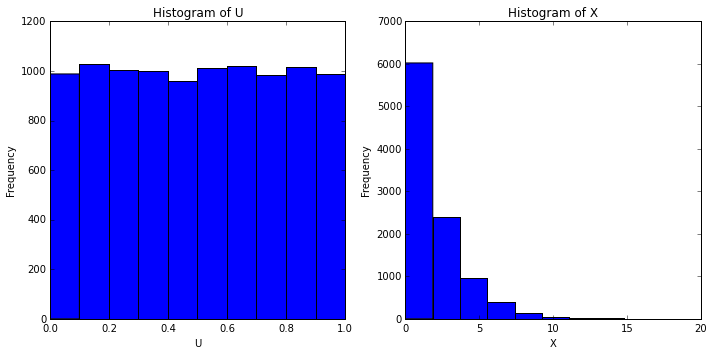

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(U)
plt.title('Histogram of U')
plt.xlabel('U')
plt.ylabel('Frequency')


plt.subplot(122)
plt.hist(X)
plt.title('Histogram of X')
plt.xlabel('X')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1.3 Accept/Reject Algorithm

Want to sample randomly from a distribution over (say) $X = (0., 1.)$. $f(x)$ is bounded by some ``M`` maximum.

* Generate $x_i$ ~ $Unif(0, 1)$ 
* Generate $y_i = u_iM$ where $u_i$ ~ $Unif(0, 1)$
* Reject points above $f(x)$ (density curve). Accept dots below.
    * if $y_i <= f(x_i)$ then accept $x_i$.
    * if $u_i <= \frac{f(x_i)}{M}$ then accept
    * else reject

Pros:
* Simple

Cons
* Have to find the maximum (hard)
* Inefficient (low acceptance rate)

Alternative (better):
* Bound the distribution more closely
* Still inefficient, still need maximum

### 1.3.1 MCMC algorithm

Markov-Chain Monte Carlo:
* Monto Carlo: random accept/reject aspect.
* Develop a chain of values, $x_0, x_1, ... x_i$
    * To generate next step $x_{i+1}$, only consider $x_i$.
    * Markov property is that I only consider the current state.

Suppose we have some distribution, and a starting value from that distribution $x_0$. To generate $x_1$:
* Given $x_i$, propose some nearby value: $x_{i+1}^* = x_i + noise$.
* If $f(x_{i+1}^* > f(x_i)$, then accept $x_{i+1} = x_{i+1}^*$. (generalized by...)
* If $f(x_{i+1}^* <= f(x_i)$, then sometimes accept...
    * Accept if: $u_{i+1}^* < \frac{f(x_{i+1}^*)}{f(x_i)}$, where $u_{i+1}^*$ ~ $Unif(0, 1)$

In [8]:
df = lambda x: 0.7*norm.pdf(x, loc=2, scale=1) + 0.3*norm.pdf(x, loc=5, scale=1)    # Some PDF.

In [9]:
density_data = zip(*[(x, df(x)) for x in np.arange(-3, 12, 15./200)])

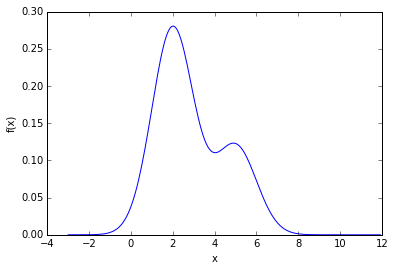

In [10]:
plt.plot(*density_data)
plt.ylabel('f(x)')
plt.xlabel('x')
plt.show()

Generate a random proposal value within (say) +/- 2.

In [12]:
rproposal = lambda x_i: x_i + np.random.uniform(-2., 2.)

In [17]:
x = [3]      # Arbitrary starting point.
x_star = [3]
x_star.append(rproposal(x[0]))    # Propose the next value.

if (df(x_star[1]) / df(x[0])) > np.random.uniform(): 
    x.append(x_star[1])    # Accept.
else:
    x.append(x[0])    # Reject.

In [18]:
x

[3, 4.884370402635162]

In [30]:
def eval(x_prev, x_prop):
    if (df(x_prop) / df(x_prev)) > np.random.uniform(): 
        return x_prop
    return x_prev

In [33]:
x, x_star = [3], [3]
for i in xrange(10):
    x_star.append(rproposal(x[-1]))
    x.append(eval(x[-1], x_star[-1]))

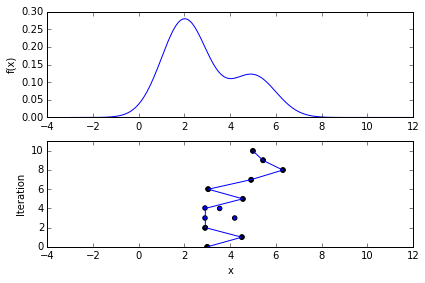

In [34]:
plt.subplot(211)
plt.plot(*density_data)
plt.xlim(-4, 12)

plt.ylabel('f(x)')

plt.subplot(212)
plt.plot(x, range(len(x)))
plt.scatter(x, range(len(x)))
rejected = lambda x_a, x_p: 'black' if x_a == x_p else 'blue'
plt.scatter(x_star, range(len(x)), c=[rejected(x[i], x_star[i]) for i in range(len(x))])
plt.xlim(-4, 12)

plt.ylim(0, len(x))
plt.xlabel('x')
plt.ylabel('Iteration')
plt.tight_layout()
plt.show()

If the proposal is generated in a non-uniform fashion, then the accept/reject rule must change. 

Accept iff: $u_{i+1} <= \frac{f(x_{i+1}^*)}{f(x_i)}\frac{g(x_i| x_{i+1}^*)}{g(x_{i+1}^*| x_i)}$

$g(x_{i+1}^*|x_i)$ is the density of the proposal distribution, centered at $x_i$.

In [89]:
g_unif = lambda x_u, y_u: uniform.pdf(x_u)*uniform.pdf(y_u)/uniform.pdf(x_u)
g_norm = lambda x_u, y_u: norm.pdf(x_u)*norm.pdf(y_u)/norm.pdf(x_u)

In [20]:
def MCMC(df, start, rprop, dprop=None, N=1000):
    """
    Perform Markov-Chain Monte Carlo simulation.
    
    Parameters
    ----------
    df : callable
        Target distribution.
    start : float
        Starting value.
    rprop : callable
        Proposal function.
    dprop : callable (proposed, current)
        (default: None) Gives the density of the proposal function
        centered on the current value.
    N : int
        Number of iterations
        
    Returns
    -------
    chain : list
        Markov chain of size N.
    """
    if dprop is None:   # Treat as symmetric.
        dprop = lambda to, fr: 1.
        
    chain = [start]
    for i in xrange(N):
        x_star = rprop(chain[-1])
        r1 = df(x_star) / df(chain[-1])
        r2 = dprop(chain[-1], x_star) / dprop(x_star, chain[-1])
        if r1*r2 > np.random.uniform():
            chain.append(x_star)
        else:
            chain.append(chain[-1])
    return chain

In [21]:
def trace_plot(chain):
    plt.plot(chain)
    plt.ylabel('Value')
    plt.xlabel('Iteration')
    plt.show()

In [22]:
chain = MCMC(df, 2, rproposal, N=1000)

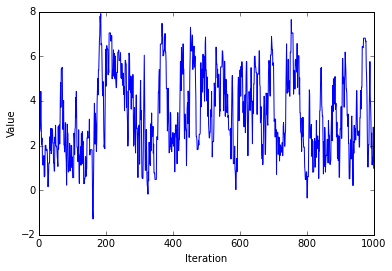

In [23]:
trace_plot(chain)

In [24]:
chain += MCMC(df, chain[-1], rproposal, N=10000)

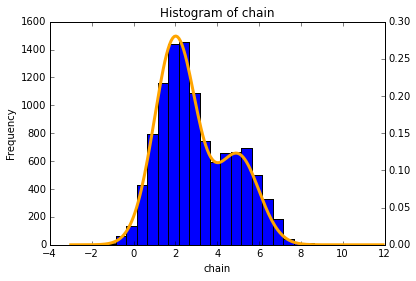

In [27]:
plt.hist(chain, bins=20)
plt.title('Histogram of chain')
plt.xlabel('chain')
plt.ylabel('Frequency')
ax = plt.gca()

# Plot the target density function.
ax2 = ax.twinx()
ax2.plot(*density_data, c='orange', lw=3)
plt.show()

Pros (compared to bounded scatter method):
* More efficient.
* No need to find maximum value.

Cons:
* Still need to decide on a good proposal distribution.
* Need a starting value.

#### With asymmetric proposal distribution

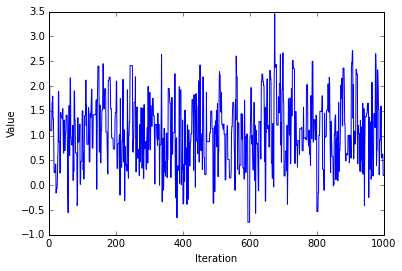

In [123]:
chain = MCMC(df, 2, rproposal, g_norm, N=1000)
trace_plot(chain)

### 1.3.2 Common problems

In [116]:
p_small = lambda x: x + np.random.uniform(-0.1, 0.1)
chain = MCMC(df, 2, p_small, N=1000)

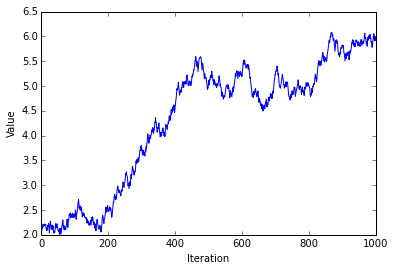

In [117]:
trace_plot(chain)

In [118]:
p_large = lambda x: x + np.random.uniform(-30., +30.)
chain = MCMC(df, 2, p_large, N=1000)

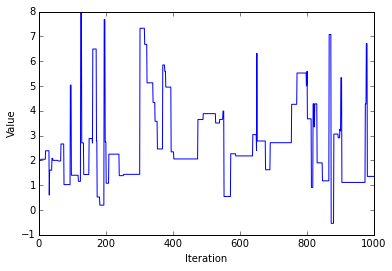

In [119]:
trace_plot(chain)

#### Burn-in

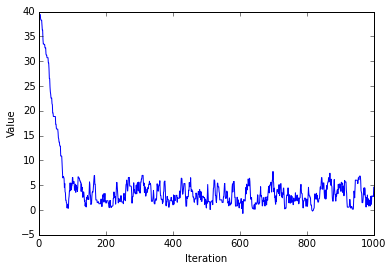

In [120]:
chain = MCMC(df, 40, rproposal, N=1000)
trace_plot(chain)

In [121]:
def trace_plots(chains):
    for chain in chains:
        plt.plot(chain)
    plt.ylabel('Value')
    plt.xlabel('Iteration')
    plt.show()

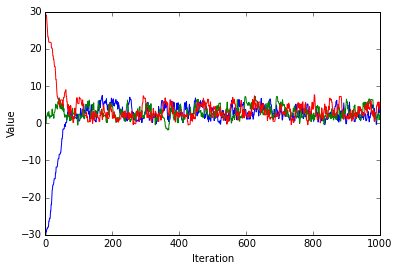

In [122]:
chain1 = MCMC(df, -30., rproposal, N=1000)
chain2 = MCMC(df, 0., rproposal, N=1000)
chain3 = MCMC(df, 30., rproposal, N=1000)
trace_plots([chain1, chain2, chain3])